# <span id="chap-concepts"></span> Concepts in network science

We'll start by getting an overview of the basic modern ideas in complex networks and complex processes. As you'll appreciate, this is potentially a *very* big topic indeed, and we can do no more than scratch the surface here. Our goal in this chapter is to introduce enough concepts to get started in exploring complex networks.

As a vehicle for explaining the ideas, we'll use a very *un-complex* network: the simple square mesh graph. We'll use Python's `NetworkX` library to build and manipulate these meshes, and the `matplotlib` library to visualise them, which will also let us introduce the key programmatic concepts in using these libraries for network science. We'll work as far as possible without mathematics, keeping the discussion purely in terms of the concepts and their relationships, and trying to link them to common real-world examples wherever possible.

In the [next chapter](er-networks.ipynb) we'll use the concepts we develop here as they apply to the simplest form of complex networks, and build up from there. We'll expand the mathematics of the concepts we introduce here, as well as the computational aspects of analysing the properties of such networks.

## Setting up the software environment

We need several Python libraries: there's more information in the [software chapter](software.ipynb). The most important is `NetworkX`:

In [1]:
import networkx as nx

Network analysis is quite mathematical, so we'll also need `numpy` to let us manipulate arrays and other structures efficiently:

In [2]:
import math
import numpy as np
import numpy.random as rnd

Notice that we bring in `numpy`'s random number functions. A lot of network science involves creating networks using stochastic processes driven by a source of random numbers. The `rnd.random()` function provides a source of uniformly-distributed random numbers between 0 and 1 that we can use to generate other distributions as we need them.

Finally we need the ability to draw graphs of network properties, and the networks themselves. The best library for this is `matplotlib`, which integrates well with IPython notebooks and allows graphics to be included in-line within a notebook as high-quality [Scalable Vector Graphics](https://en.wikipedia.org/wiki/Scalable_Vector_Graphics) (SVG):

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Graphs and networks

Everything that follows relates to *networks*. A network (or *graph*) is a collection of *nodes*, pairs of which are connected by *edges*. The total number of nodes in the network is often referred to as the *order* of the network.

(Refering to these structures as "graphs" is initially confusing for people who think of graphs as a plot of the relationships among two (or more) variables. It's especially confusing in this context, as we'll frequently be drawing this kind of graph when exploring the properties of the other kind of graph &ndash; the network. For this reason we'll try to use the term "network" for the node-and-edge structure, and keep "graph" for the line-and-error-bar structure. It's important to bear in mind, though, that terms like *network* and *graphs* as well as *network science* and *graph theory*, can be used somewhat interchangeably.)

### Building a mesh

`NetworkX` represents graphs as collections of nodes and edges. The set of nodes is indexed by any hashable Python object: we'll typically use numbers, but we'll write the code to be portable to other node identifiers.

We can build a graph in a number of ways. `NetworkX` allows us to create an empty graph using the `nx.Graph()` constructor, which can then have nodes and edges added. We can then use the various functions described in the `NetworkX` documentation to add nodes and edges. Most usefully we have:

* `g.add_node( n )` adds a node called `n` to the network `g`
* `g.add_nodes_from( ns )` adds a sequence of nodes iterated from `ns`
* `g.add_edge( s, t )` adds an edge between nodes `s` and `t`
* `g.add_edges_from( es )` iterates edges from `es` and adds them to `g`

A lot of the time we want to construct networks computationally, taking some parameters and creating a network according to some process. `NetworkX` provides several "generator" functions that create networks with different properties: for the purposes of this chapter, we'll define another generator function, `mesh_graph()`, that creates regular meshes. The code for this function is:

In [4]:
def mesh_graph( mesh_rows, mesh_columns ):
    """Create a regular mesh with the given dimensions."""
    
    # create the graph and populate with nodes indexed by a single integer
    mesh = nx.Graph()
    mesh.add_nodes_from(xrange(mesh_rows * mesh_columns))
    
    # add edges to the main body of the mesh
    for r in xrange(0, mesh_rows - 1):          # sweep top-left to bottom-right
        for c in xrange(0, mesh_columns - 1):
            i = r * mesh_columns + c
            mesh.add_edge(i, i + 1)             # edge to right neighbour
            mesh.add_edge(i, i + mesh_columns)  # edge to south neighbour (row below)
        
    # add edges along the right-hand column
    for r in xrange(0, mesh_rows - 1):
        i = (r + 1) * mesh_columns - 1    
        mesh.add_edge(i, i + mesh_columns)      # edge to south neighbour (row below)
        
    # add edges along the bottom (south) edge
    for c in xrange(0, mesh_columns - 1):
        i = (mesh_rows - 1) * mesh_columns + c        
        mesh.add_edge(i, i + 1)                 # edge to right neighbour
        
    return mesh

Let's work through the process. Firstly we create an empty network and populate it with nodes. We then add edges. For all except the last column and row, we add an edge to the right and south neighbours: a moment's though should convince you that this fleshes out most of the mesh. We then add edges to complete the mesh in the final column and row.

This is perhaps a slightly more involved process than you might have expected, but we have to be careful that we add all the edges we want *and no more*. Spefifically, although all the non-edge nodes have links going in four directions, there's only one edge between each pair of nodes, and we have to be careful not to add too many.

Notice how `NetworkX` manipulates the network. We add edge indices (integers in this case) and then use these to identify edges at the ends of edges.

We can now use our function to create a network with whatever dimensions we desire:

In [5]:
mesh = mesh_graph(10, 10)

What does the network look like? We can use `NetworkX` to visualise it, which in turn uses `matplotlib` to do the actually plotting:

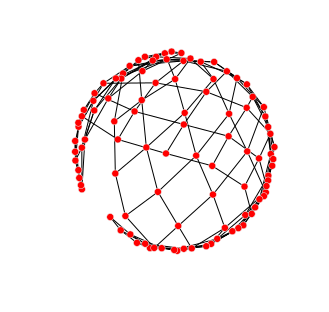

In [6]:
# create a figure with no axes
fig = plt.figure(figsize = (5, 5))   # an in-line figure
plt.gca().set_axis_off()             # turn off the axes, that mean nothing for networks

# use MetworkX to draw the network, without node labels
nx.draw_networkx(mesh, with_labels = False, node_size = 50)

It's kind of mesh-y, I suppose, but it doesn't really look much like a mesh as we usually imagine them. And this brings up an important point. A network has an inherent *topology*, in terms of which nodes are adjacent to others; but it doesn't have an inherent *geometry* that lets us arrange nodes (and edges) on the page. We can impose a number of geometries on a network, and `NetworkX` chooses a default approach (called a "spring" layout) that attempts to provide a "good" geometry. `NetworkX` provides a number of helper functions that impose other geometries on networks too, many of which are very good for helping to extract key features visually.

In this case we can probably agree that the default choice fails, in that we would expect a mesh to be laid-out as a square or other regular shape. We can get this layout, but to do so we have to define our own layout function. We'll actually do slightly more than this: we'll define a layout function that arranges the nodes in a grid, and then wrap this in a helper function we can call when we need it:

In [7]:
def mesh_positions( mesh, mesh_rows, mesh_columns ):
    """Return a dictionary of positions for nodes laid out in a mesh."""
    pos = dict()
    rh = 1.0 / (mesh_rows)                # row height
    cw = 1.0 / (mesh_columns)             # column width
    
    # run through the rows and columns, laying-out nodes as we go
    # and storing their co-ordinates into pos. Co-ordinates lie in
    # the range [0.0 ... 1.0]
    nodes = mesh.nodes_iter()
    try:
        for r in xrange(mesh_rows):
            for c in xrange(mesh_columns):
                n = nodes.next()
                pos[n] = (c * cw,
                          1.0 - r * rh)   # lowest nodes in the top row, not the bottom
    except StopIteration:
        # ran out of nodes, so drop through
        pass
    
    return pos

def draw_mesh(g, mesh_rows = None, mesh_columns = None, **kwds):
    """Draw the graph with a mesh layout.
    
    g: the network to position
    mesh_rows: the number of rows in the mesh
    mesh_columns: the number of columns in the mesh
    """
    
    # fill in the argument defaults where not specified
    if mesh_rows is not None:
        if mesh_columns is None:
            # rows fixed, set the columns
            mesh_columns = g.order() / mesh_rows
            if g.order() % mesh_rows > 0:
                mesh_columns = mesh_columns + 1
    else:
        if mesh_columns is None:
            # neither rows nor columns fixed, set both
            mesh_rows = mesh_columns = int(np.sqrt(g.order()))
            if mesh_rows * mesh_columns < g.order():
                mesh_rows = mesh_rows + 1
        else:
            # columns fixed, set the rows
            mesh_rows = g.order() / mesh_columns
            if g.order() % mesh_columns > 0:
                mesh_rows = mesh_rows + 1

    # compute the layout using these dimensions
    pos = mesh_positions(g, mesh_rows, mesh_columns)
    
    # pass through the layout and any additional keyword arguments
    return nx.draw_networkx(g, pos, **kwds)

We can now use the helper function to draw the network as we would expect:

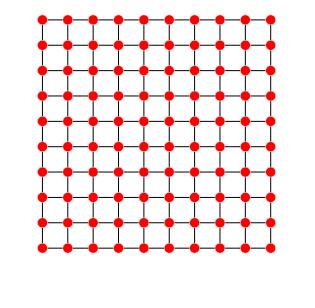

In [8]:
fig = plt.figure(figsize = (5, 5))
_ = plt.gca().set_axis_off()             # axes off
_ = plt.gca().set_xlim([-0.05, 1.05])    # control the space around the plot
_ = plt.gca().set_ylim([-0.05, 1.05])

# draw the mesh
draw_mesh(mesh, with_labels = False, node_size = 100)

Much better.

### <span id="sec_navigation"></span> Navigation

The nodes and edges form the topology of a network. Going back to Euler's approach to [modelling the K&ouml;nigsberg bridges](introduction.ipynb#sec_konigsberg), it's easy to consider nodes to be "places" in some sense, and edges to be "routes" between them. This suggests that we can think of a network like we think of a map, in which we can "be" at a given "place" and "move" to an "adjacent" place by traversing a "route". This "navigation" analogy is so compelling that we'll use such terms even for networks that have no link to geography.

Edges define the adjacencies of a network: two nodes are *adjacent* of there is an edge between them. Starting from some node, we can *traverse* one of the edges incident on that node to reach its neighbour, and from there traverse further edges to reach other nodes. Such a sequence of node-edge-node-edge-... forms a *path*. A node is said to be *reachable* from another if there is a path from the latter to the former. The *length* of a path is the number of edges we traverse from one end to the other. (Adjacencies are therefore just paths of length one.)

### <span id="sec_connectedness"></span> Connectedness and the construction of paths

The first question we generally ask about navigation is: can we construct a path between any pair of nodes in the network? There are actually two questions combined into one here: is it possible *in principle* to build such a path?; and can we actually *find* such a path even if we know one exists?

The first question deals with the *connectedness* of a network. A network is *connected* if there exists a path between every pair of nodes, and *disconnected* otherwise. A disconnected network is really two networks side by side, of course.

The second question is not one that's easily answered. In the mesh we've been considering, it's easy to see how to construct a path between any pair of nodes: go "across" the rows until the appropriate column, and then "up" (or "down") to the appropriate row. This is sometimes called *Manhatten routing*, and is an algorithm that will be familiar to anyone who's ever visited a major American city. It is probably most notable for *not* working in non-mesh cities such as are found in much of Europe (and in smaller, older, American towns), where the network of streets is more complex. In a random graph, it will clearly be considerably harder to find a path.

Fortunately in network science we often don't need to be able to find specific paths: it's enough to know that they exist (or not) in principle, or even sometimes that they *probably* exist.

### <span id="sec_directed"</span> Directedness

In the model above, edges are *undirected*, in the sense that one can traverse an edge in either direction. This is fine if edges represent a connection between two nodes that is in some sense symmetrical or bi-directional. If nodes represent people and edges represent the relationship "knows", then this is clearly the case: if *A* knows *B* then (presumably) *B* also knows *A*. It is sometimes useful to model relationships that are asymmetric, however: if edges represent "is an ancestor of", then one needs to know whether *A* is an ancestor of *B* or *vice versa*. The relationship represented by the edge is directional, and we capture this by saying that the edges are *directed*. We usually indicate this using an arrow pointing in the direction of the edge.

In terms of navigation, directed edges can only usually be traversed in the direction indicated by the arrow, respecting the direction of the edge. Directedness complicates navigation by forbidding some moves, and complicates the definition of connectedness through the possibility of having parts of the network that can reach all other parts while remaining unreachable themselves.

### Parallel edges and self loops

Suppose we have two nodes *A* and *B*, and two undirected edges between them. This provides two "routes" by which we can navigate between the two nodes. The two edges are referred to as *parallel*: they have the same start and end points.

Parallel edges are needed in some network models, but as a general rule we try to exclude them for reasons of mathematical simplicity (which will become apparent later). A network is often defined, therefore, to have no parallel edges &ndash; or, to put it another way, there is only ever one edge between any pair of nodes.

If a network is directed, there may be two edges between *A* and *B* running in opposite directions. For networks with directed edges, we regard edges as parallel only if they have the same start and end points *and* the same direction.

It might also happen that a node *A* has an edge that connects it to itself: *A* is both the start and end point for the edge. Such edges are called *<span id="def_self_loop">self loops</span>*. Again, self loops are sometimes important when modelling phenomena as networks; and, again for reasons of simplicity, we often enforce that networks have no self loops, so all edges have distinct start and end points.

An undirected network with no parallel edges and no self-loops is sometimes called a *<span id="def_simple_network">simple network</span>*. Most of the networks we look at in this book are simple (in this sense). Their mathematics is simpler, and they're still powerful enough to model a huge range of phenomena and applications.

## <span id="sec_static_properties"</span> Static properties

If we are given a network, we can study it to determine some important properties about it. It turns out that these properties are often very illuminating both of the structure of the network and of the ways in which processes running on it will evolve.

In this section we'll define some basic propeties of networks. These properties are all *static*: for a given network, we can work them out and they never change unless the network itself is changed (see [adaptation](#sec_adaptation) below).

### <span id="sec_degree"></span> Node degree

Perhaps the most basic property if a node in a network is its *degree*, by which we mean the number of other nodes to which it is directly connected. In general nodes may have any whole-numbered (integer) degree &ndash; including zero, for an *<span id="def_isolated_node">isolated</span>* node that is not connected to any other.

We can of course calculate the total degree of a network by summing-up the degrees of all the nodes. For a [simple network](#def_simple_network), the total degree will be twice the number of edges in the network, since every edge is incident on two different nodes. 

### <span id="sec_degree_distribution"></span> Degree distribution

We can now define what is often seen as the critical property of a complex network: its *degree distribution*. The degree distribution is the way in which the degrees of nodes varies across the entire network: the number of nodes in the network with degree 1, degree 2, and so forth.

Clearly any network will have a largest (maximal) and smallest (minimal) degree:

In [44]:
# extract the degrees of all the nodes in the mesh
dist = mesh.degree().values()

# compute the bounds and histogram
min_degree = min(dist)
max_degree = max(dist)

print "Mesh minimal degree {min}, maximal degree {max}".format(min = min_degree, max = max_degree)

Mesh minimal degree 2, maximal degree 4


What about the degrees in between? The easiest way to look at degree distribution, at least for networks with only a moderate range of degrees, is with a histogram. To show how the degree distribution histogram is created, we'll draw the mesh with nodes coloured according to their degrees, and then plot the corresponding histogram of degrees:

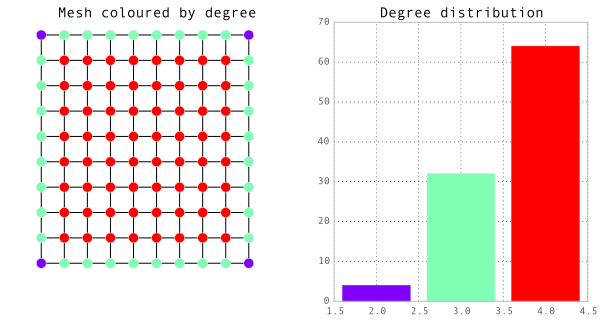

In [46]:
# build a histogram of degrees values
(hist, bins) = np.histogram(dist,
                            bins = range(min_degree, max_degree + 2))

# colour map we'll use for indicating the degree of a node
colour_map = plt.cm.rainbow

# draw the mesh, colouring the nodes according to their degree
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1, 2, 1)
_ = ax1.set_title("Mesh coloured by degree")
_ = ax1.set_axis_off()
draw_mesh(mesh, ax = ax1, with_labels = False, node_size = 100,
          node_color = dist, cmap = colour_map, vmin = min_degree, vmax = max_degree)
_ = ax1.set_xlim([-0.05, 1.05])
_ = ax1.set_ylim([-0.05, 1.05])

# draw the degree distribution histogram, colouring the bars
# to correspond to the colours of the mesh drawing
ax2 = fig.add_subplot(1, 2, 2)
_ = ax2.set_title("Degree distribution")
bars = ax2.bar(bins[:-1], hist, align = 'center')
for i in xrange(len(bars)):
    bars[i].set_color(colour_map((bins[i] - min_degree + 0.0) / (max_degree - min_degree)))
    
_ = plt.show()

Most of the nodes have degree four, lying in the middle of the mesh. There are a smaller number of edge nodes with degree three, and an even smaller number (actually just the four corners) with degree two.

Why is degree distribution considered so critical? The degree of a node determines how many neighbours it has; the degree distribution controls the liklihood of nodes with lots of neighbours, and so indirectly the liklihood that a node is neighbour to *another* node with lots of neighbours, and so forth. But there's more to it than that. The degree distribution controls whether the network is mainly made up of high-degree nodes, mainly or low-degree nodes, or somehow balanced between them.

But it's the interactions with other properties that make degree distribution perhaps the most critical single property of a network. To see why, consider two networks with the same number of nodes where one has mainly high-degree nodes and one mainly low-degree nodes. Suppose further that we link nodes together randomly. If lots of nodes have high degree, then clearly each node will in general be linked to a higher proportion of nodes in the network than in the case where nodes have low degree. And this implies that nodes are "closer together": one in general has to traverse fewer edges to get between a given pair of nodes than in the low-degree case. So the degree distribution affects the [average shortest path](#sec_paths) between any two nodes selected at random: the graph has a smaller diameter. And *this* in turn is important, because (as we'll see later) a lot of processes that run over networks are affected critically by the diameter, since they can spread more efficiently through networks with low diameters. The degree distribution is the strongest contributor to diameter, although there are other contributing factors too: we discuss these more below when we talk about [topological sensitivity](#sec_small_topology_changes) and [assortativity](#sec_assortive).

The word "distribution" suggests a link to probability, and indeed we can view the degree distribution exactly like this: if we choose a node from the network at random, what is the probability that we will choose a node with a given degree (say, degree 2)? We can convert the number of nodes with degree $k$ into the probability that a randomly-chosen node has degree $k$ by dividing the number of nodes of degree $k$ by the number of nodes in the network, $N$.

### <span id="sec_mean_degree"</span> Mean degree

Appealing to probability in this way also suggest some other features we should look for in examining node degrees. For example, do we see different probability distributions of node degrees in different networks? The degree distribution could be uniform, normal, exponential, or could in principle take the form of *any* other probability distribution. We can also apply statistical summary techniques to the degree distribution, for example to work out the mean degree, the variance and standard deviation of the degree distribution, and other numbers &ndash; all of which tell us something about the global properties of the network we're considering.

For the moment, let's just work out the mean degree of our mesh. There are several ways to do this, so we'll use a general method: enumerate the degrees of all the nodes in the mesh, and use this to compute the mean:

In [11]:
N = mesh.order()

# count the number of nodes with each degree
degree_n = np.zeros(max_degree + 1)
for k in xrange(min_degree, max_degree + 1):
    degree_n[k] = len([ v for v in dist if v == k ])
    
# compute the mean degree over the entire array
# convert count to probability by dividing through by N, then
# multiply by the corresponding degree
k_mean = sum((degree_n / N) * range(0, max_degree + 1))

print "Mean degree of mesh = {mk}".format(mk = k_mean)

Mean degree of mesh = 3.6


To calculate the mean we've calculated the number of nodes having each degree in the distribution; converted this count into a probability by dividing by the total number of nodes in the mesh; multiplied each of the resulting probabilities by the degree to which they refer; and summed these expected values to arrive at the mean. Having extracted the degree counts using a loop, we can do the rest of the calculation in a single line using `numpy`'s array operations, which give a very compact notation and a very efficient computation.

### <span id="sec_assortive"></span> Assortativity

From the discussion above, you might think that knowing the degree distribution tells you everything you need to know about a network. But part of what makes complex networks complex is that this isn't always the case.

Let's ask another question: if we choose a node at random, and then choose one of its neighbours at random, what would we expect the degree of that neighbour to be? The obvious answer would be the mean degree, but this turns out not to be the case: the first of many counter-inituitive results in our study.

Why is this the case? The mathematical reason is that a node is more likely to be adjacent to a node of high degree simply because such nodes have more opportunities to be connected: they have links to more nodes, by definition. That means that, if the network has been wired-up randomly, the expected degree of a neighbouring node is *higher* than the average (mean) degree. We'll defer demonstrating this until later.

But there is also the possibility that the network has *not* been wired-up randomly, and this is something that we encounter frequently in the real world. It might be the case that nodes of high degree are linked preferentially to *other* nodes of high degree for some reason, while low-degree nodes are more likely to be linked to other low-degree nodes. In that case, the expected degree of the neighbour of a node is affected by the degree of that node itself, because if we know the node has high degree (for example) we know that its neighbours are likely to also have high degree.

A stylised example of this comes from social science. Suppose we build a network whos enodes are individuals and whose edges indicate friendship: there is an edge between two nodes if these people are friends. What would we expect of this network? The degree of a node is a measure of the popularity of a person. Intuitively &ndash; and possibly only apocryphally, so we'd have to check carefully if this was a real experiment &ndash; we might think that popular people are friends with other, popular, people, while the unpopular associate more with other loners. The degree of a node (the person's popularity) gives some information the degree of a neighbour (the popularity of one of their friends, chosen at random).

We call such networks *assortive*. They're very common and, as you might expect from the experiment we did with [node degree](#sec_degree_distribution), the change affects the diameter and other properties of the network. We'll explore some more detailed examples later. The dual of an assortive network is one in which high-degree nodes attach preferentially to *low-degree* nodes, and *vice versa*. These networks are called *dissortive* (or occasionally *disassortive*), and also do not behave as you'd expect from the random case. 

There are two important points from this. Firstly, the degree distribution, while important, is not *all*-important: there's more we need to know in order to determine how a network will behave. Secondly, the assortativity is stochastic: affects the *probability* that a high-degree node is adjacent to a low-degree node, but does not *preclude* the node having a low-degree neighbour. Indeed, a moment's thought shows that this *has* to be the case: if high-degree nodes can only have high-degree neighbours (and analogously for low-degree nodes), the network would be split into two disconnected classes with no links between them. Assortativity is a *tendency*, and one needs to know the strength of the assortativity in order to understand the behaviour properly.   

### <span id="sec_components"></span> Components

[Earlier](#sec_connectedness) we introduced the idea of connectedness, where every node in a network is accessible (via at least one path) from every other node. Our mesh is clearly a connected network, and many real-world networks are: but some aren't, a good example being the road network of the British Isles, in which the roads of Great Britain are disconnected from the roads of Ireland, the Isle of Man, the roads on Lewis and Harris, and so forth. A single "network" is actually composed of several sub-networks that may themselves be connected. We refer to these sub-networks as *components*. A network may have one or more components. These may be known (as in the case of island road networks) or unknown (if we built a network randomly).

`NetworkX` can quite happily support networks with components. For example, we might build a network consisting of two meshes side by side, without connections:

In [12]:
(M1, M2) = (mesh_graph(5, 5), mesh_graph(5, 5))
M = nx.union(M1, M2, rename = ("M1-", "M2-"))

Here we've created two meshes and then used `NetworkX`'s operators to combine them into a new network. `union()` takes two networks and puts them together into a single network. Since in our case the two initial networks share node names, we use the `rename` option to prefix the name of each node in the union network with the name of the network from which it came:

In [13]:
print M.nodes()

['M1-11', 'M1-10', 'M1-13', 'M1-12', 'M1-15', 'M1-14', 'M1-17', 'M1-16', 'M1-19', 'M1-18', 'M2-10', 'M2-11', 'M2-12', 'M2-13', 'M2-14', 'M2-15', 'M2-16', 'M2-17', 'M2-18', 'M2-19', 'M1-9', 'M1-8', 'M1-1', 'M1-0', 'M1-3', 'M1-2', 'M1-5', 'M1-4', 'M1-7', 'M1-6', 'M2-2', 'M2-3', 'M2-0', 'M2-1', 'M2-6', 'M2-7', 'M2-4', 'M2-5', 'M1-20', 'M1-21', 'M1-22', 'M1-23', 'M1-24', 'M2-9', 'M2-8', 'M2-21', 'M2-20', 'M2-23', 'M2-22', 'M2-24']


Clearly the resulting network will not have any edges between the two original meshes, and so will consist of two components:

In [13]:
print "Mesh has {c} components".format(c = nx.number_connected_components(M))

Mesh has 2 components


If we add an edge between the two components, they will collapse into a single component:

In [14]:
M.add_edge('M1-10', 'M2-10')
print "Mesh now has {c} components".format(c = nx.number_connected_components(M))

Mesh now has 1 components


### <span id="sec_connectivity"></span> Connectivity

If a component is a connected sub-network of a network, then by definition there is a path between all pairs of nodes. Paths are constructed from sequences of nodes and edges, so if we started removing nodes (and all incident edges) from a component we may eventually cause the component to become disconnected, splitting into two smaller components. The set of nodes we need to remove in order to disconnect a component is called a *cut* (or sometimes a *vertex cut*). This begs the question: *how many nodes* do we need to remove before a network or component fragments? Or, put another way, what is the size of the smallest cut? This number is called the *connectivity* of a network, denoted $\kappa(G)$ for a network $G$. A network is $k$-connected if its connectivity is at least $k$: that is to say, a network that is 3-connected is also 2- and 1-connected. 3-connectivity says that there are three nodes that, if removed, will split (or *partition*) the network. That isn't to say that removing *any* three nodes will do so, just that there *are* three nodes (somewhere) that constitute a cut, and no two nodes will do the job. There may be several cuts with three nodes, or just one. 

Let's consider a mesh of four nodes:

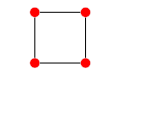

In [15]:
G = mesh_graph(2, 2)

fig = plt.figure(figsize = (2, 2))
_ = plt.gca().set_axis_off()
_ = plt.gca().set_xlim([-0.05, 1.05])
_ = plt.gca().set_ylim([-0.05, 1.05])
draw_mesh(G, with_labels = False, node_size = 100)

How many nodes to we need to remove to disconnect this network? If we remove any one node, the mesh stays connected, but if we remove two opposite nodes, it disconnects: there is no path between the two remaining corners. So this mesh is 2-connected.

How about a larger mesh?

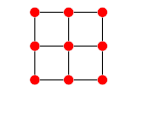

In [16]:
G = mesh_graph(3, 3)

fig = plt.figure(figsize = (2, 2))
_ = plt.gca().set_axis_off()
_ = plt.gca().set_xlim([-0.05, 1.05])
_ = plt.gca().set_ylim([-0.05, 1.05])
draw_mesh(G, with_labels = False, node_size = 100)

How many nodes to we need to remove now? Actually, still only two: the two nodes on either side of a corner node, which partitions the mesh into two parts: the corner node, and everything else. Of course we could remove other, larger, sets of nodes (like a diagonal) and get a cut, but the smallest cut for this network is two.

### <span id="sec_k_cores"></span> *k*-cores

Our earlier discussion of [degree distribution](#sec_degree_distribution) highlighted that a network may have nodes with similar or very different degrees. Our meshes have all been rather regular, in the sense that most of the nodes (those not on the edges or corners) have had degree four. As the mesh gets larger, the proportion of degree-four nodes increases.

In many circumstances, the degree of a node corresponds in some way to its importance. In the World Wide Web, for example, we might say that nodes (pages) with high degree (lots of links) are more important than those pages with less links. Links from important pages to important pages might be regarded as more significant than those from less important pages, since the "reputation" of the former link is greater than the latter. (It is this line of reasoning that underpins Google's [PageRank algorithm](https://en.wikipedia.org/wiki/PageRank.)

...

### Clustering and modularity

### Community detection

### Motifs

## <span id="sec_semi_static_properties"</span> Semi-static properties

The above properties are all *static*, in the sense that they're properties of the network "as it stands". There are other properties that relate to navigation that we refer to as *semi-static* properties and discuss in this section, and still more *dynamic* properties relating to complex processes that we defer to the [next section](#sec_dynamic_properties).

Navigation is the most basic process we can conduct on a network, allowing us to "move" between nodes along edges. The semi-static properties we're concerned with concern the properties of edges and sequences of edges, which turn out to affect the dynamics of processes very strongly. They're all related to notions of [degree](#sec_degree) that we looked at earlier.

### <a id="sec_paths"></a> Paths, cycles, and shortest paths

We mentioned paths [earlier](#sec_navigation), when we first introduced the idea of navigating through a network. A path is an alternating sequence of nodes and edges, starting and ending with a node, where the the nodes are linked by the edges and we respect the [direction](#sec_directed) of edges if they have one. The *length* of the path is the number of edges it contains. Two nodes linked by an edge are adjacent, which is the same as saying they are connected with a path of length one. Any sub-part of a path with nodes at both ends is also a path.

If we allow self-loops, a path may include an edge that has the same node as its start and end. This is the simplest sort of *cycle* (of length one), and complicates what we mean by the length of a path as a navigator can go "round and around" the cycle indefinitely. But even if we outlaw self-loops (cycles of length one) and parallel edges (cycles of length 2) we can still get longer cycles (of length three or more), where for example node $A$ has an edge to node $B$ which has an edge to node $C$ which as an edge back to node $A$.

(Sometimes we refer to a network that has any cyclic path as *cyclic*, and a network with no such paths as *acyclic*. However, virtually all complex networks are cyclic by this definition.)

What is the length of a cycle? One could derive a length by counting each edge once, but that seems slightly misleading for a structure that allows a navigator to go round indefinitely. By convention, cycles are therefore assumed to have infinite length.

Paths aren't unique, in that there will typically be several paths between two nodes $A$ and $B$. The set of such paths may exhibit many different lengths, but there will always be one or more paths that have the shortest length. We refer to such paths, unsurprisingly, as the *shortest paths* between $A$ and $B$, and the length of the shortest path as the *distance* between them. The distance between two nodes will always be finite, since if one can construct a path between two nodes at all, one can always construct a acyclic path. (We'll leave it to you to convince yourself that this is true.) 

### <span id="diameter"></span> Diameter

Shortest paths tell us something about how "quickly" we can navigate between two nodes. As such they're really a local property of the pair of nodes we're considering. But we can use the idea to generate a global property that tells us something about the network as a whole.

The shortest path between pairs of nodes clearly varies depending on which nodes we pick. It's also intuitively clear that there must be a *longest* shortest path, in other words two nodes that are as far apart as we can get within a particular network. Notice that this is the longest *shortest* path, not the longest path overall: since we can often go round cycles, there may not *be* a longest path in a network.

We refer to the longest shortest path as the *diameter* of the network. We find the diameter simply by finding the shortest paths between all pairs of nodes and then picking the largest. `NetworkX` can do this computation for us:

In [18]:
print "Diameter of 10x10 mesh = {d}".format(d = nx.diameter(mesh))

Diameter of 10x10 mesh = 18


For the mesh network, the paths corresponding to the diameter obviously run along the main diagonals, taking two steps to move to a "diagonally adjacent" node (in the absence of edges actually making diagonal nodes adjacent in the network sense). 

### <span id="sec_characteristic_path"></span> Characteristic path length

Diameter is an "extreme" measure, in the sense that it picks out a particular, largest value from the range of shortest path lengths. We might also ask what is the average shortest path &ndash; the average distance between two nodes chosen at random. This value is known as the *characteristic path length*, and clearly lies in the range between 1 and the diameter.

As for diameter, `NetworkX` has a function to compute the characteristic path length directly: 

In [19]:
c = nx.average_shortest_path_length(mesh)
print "Characteristic path length of 10x10 mesh = {ave}".format(ave = c)

Characteristic path length of 10x10 mesh = 6.66666666667


The characteristic path length is a measure of the "denseness" of the network, in the sense that a short characteristic path denotes a network in which shortest paths are indeed short.

### <a id="betweenness_centrality"></a> Betweenness centrality

Because shortest paths relate to how quickly wecan traverse a graph, they also relate to how processes can be optimised. If we want to get from $A$ to $B$ as quickly as possible, taking the shortest path sounds like the way to do it. Any process that relied on this kind of navigation &ndash; transportation, information transfer, viral infection &ndash; would be likely to behave "best" if it made use of shortest paths.

The shortest path is a property that's local to a pair of nodes; by considering the longest and average shortest paths in the network we derived the [diameter](#sec_diameter) and the [characteristic path length](#sec_characteristic_path) as global properties. But we can also relate the shortest paths to the nodes of the network to get another local property: the *betweenness centrality* of a node.

Each shortest path passes through a number of nodes between its endpoints. If we calculate the shortest paths between all pairs of nodes, we can then compute what fraction of these paths pass through each node in the network. This value is the betweenness centrality of a node, and measures how "central" it is to navigation occurring along shortest paths. A node with a high betweenness centrality sits on the shortest paths between more pairs of nodes &ndash; or, to put it another way, moving between a randomly-chosen pair of nodes along the shortest path passes through a given node with a probability given by its betweeness centrality.

`NetworkX` has a function to compute betweenness centrality, and we can use it to colour our mesh again to show the distribution of betweenness centrality values:

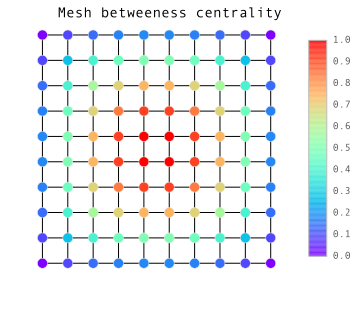

In [58]:
# compute beweenness centralities of all nodes
bcs = nx.betweenness_centrality(mesh)

# convert dictionary to array corresponding to the nodes in the mesh
bc_cols = []
for n in mesh.nodes_iter():
    bc_cols.append(bcs[n])

# colour map we'll use for indicating the betweenness centrality of a node
colour_map = plt.cm.rainbow

# draw the mesh, colouring the nodes according to their betweenness centrality
fig = plt.figure(figsize = (5, 5))
ax1 = fig.gca()
_ = ax1.set_title("Mesh betweenness centrality")
_ = ax1.set_axis_off()
draw_mesh(mesh, ax = ax1, with_labels = False, node_size = 100,
          node_color = bc_cols, cmap = colour_map)
_ = ax1.set_xlim([-0.05, 1.05])
_ = ax1.set_ylim([-0.05, 1.05])

# add a colour bar up the side
ax2 = plt.axes((0.9, 0.25, 0.05, 0.6))
cbar = matplotlib.colorbar.ColorbarBase(ax2, colour_map)
_ = plt.show()

The result probably isn't too surprising: nodes in the centre of the mesh have higher betweenness centrality that the mesh's edges or corners.

### <span id="sec_small_topology_changes"></span> The effect of small changes in topology

It's easy to talk about the degree distribution and other characteristics of a network as though they were defined precisely according to a mathematical formula &ndash; which of course they may well be, if we're creating networks for simulations. If we're studying real-world networks, however, things are unlikely to be so clean. We may find a network that is mostly (or even overwhelmingly) regular in terms of its degree distribution, but which has a small number of "extra" edges that change the degree distribution to an almost imperceptible extent. But we already know that introducing more edges can introduce short-cuts, that can reduce the network's diameter and in turn influence the evolution of processes executing on the network. This raises the question: how many short-cuts do we need to cause significant deviations?

For the purposes of this chapter, it's enough if we show that there *is* a difference introduced by these very small changes in topology. We'll do this by generating regular meshes of different sizes and computing their diameters. We'll then add a small number of edges at random to produce some short-cuts, and see to what extent this reduces the network's diameter.

Let's generate a collection of meshes of different sizes, and then compute their diameters:

In [21]:
meshes = dict()
for r in (10, 20, 30, 40, 50):
    m = mesh_graph(r, r)
    d = nx.diameter(m)
    mesh = dict(side = r,      # the mesh's "size"
                mesh = m,      # the mesh itself
                diameter = d)  # the mesh's diameter
    meshes[r] = mesh
    print "{r}x{r} mesh, diameter = {d}".format(r = mesh['side'],
                                                d = mesh['diameter'])

10x10 mesh, diameter = 18
20x20 mesh, diameter = 38
30x30 mesh, diameter = 58
40x40 mesh, diameter = 78
50x50 mesh, diameter = 98


Suppose we now add a small number of edges at random to each mesh: how does this affect their diamater? We first define a function to add random edges to a graph:

In [19]:
def add_edges_at_random( g, ne ):
    """Add edges at random to graph g.
    
    ne: number of edges to add"""
    N = g.order()
    ns = g.nodes()
    for i in xrange(ne):
        si = int(rnd.random() * N)
        ti = int(rnd.random() * N)
        g.add_edge(ns[si], ns[ti])
    return g

Let's add 2% more edges to each mesh, re-compute their diameters, and compare the ratio of diameters of the extended networks to those of the originals: 

In [25]:
ext_meshes = dict()
rs = [ 10, 20, 30, 40, 50 ]
for r in rs:
    m = meshes[r]['mesh']
    me = nx.Graph(m)       # copy the original mesh
    add_edges_at_random(me, int((me.order() + 0.0) * 0.02))
    de = nx.diameter(me)
    mesh = dict(side = r,
                mesh = me,
                diameter = de)
    ext_meshes[r] = mesh
    print "{r}x{r}: originally {d}, extended {de}, diameter ratio {ra}".format(
                    r = r,
                    d = meshes[r]['diameter'],
                    de = ext_meshes[r]['diameter'],
                    ra = (ext_meshes[r]['diameter'] + 0.0) / meshes[r]['diameter'])

10x10: originally 18, extended 16, diameter ratio 0.888888888889
20x20: originally 38, extended 22, diameter ratio 0.578947368421
30x30: originally 58, extended 27, diameter ratio 0.465517241379
40x40: originally 78, extended 29, diameter ratio 0.371794871795
50x50: originally 98, extended 31, diameter ratio 0.316326530612


It's worth taking a moment to look at those numbers. By increasing the number of edges in a network by 2%, we can shrink it's diameter to only 30% its previous value, with the effect becoming ever more pronounced for larger networks!

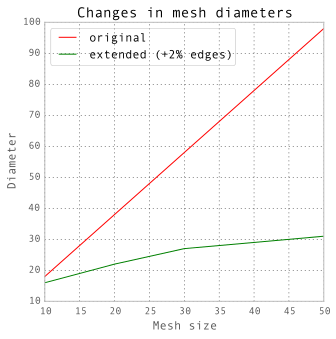

In [66]:
fig = plt.figure(figsize = (5, 5))

plt.title('Changes in mesh diameters')
plt.xlabel('Mesh size')
plt.ylabel('Diameter')
plt.plot(rs, [ meshes[r]['diameter'] for r in rs ],     'r-', label = 'original')
plt.plot(rs, [ ext_meshes[r]['diameter'] for r in rs ], 'g-', label = 'extended (+2% edges)')
plt.legend(loc = 'upper left')
_ = plt.show()

And in changing the diameter, the extra edges change all the static properties of the network. Consider the betweeness centrality metrics we had before for 10x10 meshes: what effect do an extra 2% (that is, 2) edges have on these?

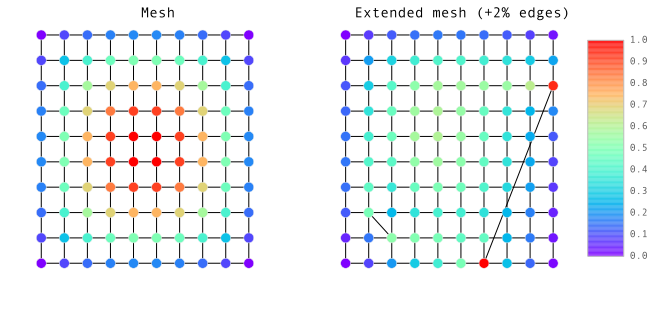

In [50]:
mesh = meshes[10]['mesh']
ext_mesh = ext_meshes[10]['mesh']

mesh_bcs = nx.betweenness_centrality(mesh)
ext_mesh_bcs = nx.betweenness_centrality(ext_mesh)

bc_cols = []
ext_bc_cols = []
for n in mesh.nodes_iter():
    bc_cols.append(mesh_bcs[n])
for n in ext_mesh.nodes_iter():
    ext_bc_cols.append(ext_mesh_bcs[n])

colour_map = plt.cm.rainbow

# original mesh
fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(1, 2, 1)
_ = ax1.set_title("Mesh")
_ = ax1.set_axis_off()
draw_mesh(mesh, ax = ax1, with_labels = False, node_size = 100,
          node_color = bc_cols, cmap = colour_map)
_ = ax1.set_xlim([-0.05, 1.05])
_ = ax1.set_ylim([-0.05, 1.05])

# extended mesh
ax2 = fig.add_subplot(1, 2, 2)
_ = ax2.set_title("Extended mesh (+2% edges)")
_ = ax2.set_axis_off()
draw_mesh(ext_mesh, ax = ax2, with_labels = False, node_size = 100,
          node_color = ext_bc_cols, cmap = colour_map)
_ = ax2.set_xlim([-0.05, 1.05])
_ = ax2.set_ylim([-0.05, 1.05])

# add a colour bar up the side
ax2 = plt.axes((0.9, 0.25, 0.05, 0.6))
cbar = matplotlib.colorbar.ColorbarBase(ax2, colour_map)

plt.savefig('mesh-ext-bc.png')

If we were to look at the degree distributions of the meshes, however, we would see very little difference:

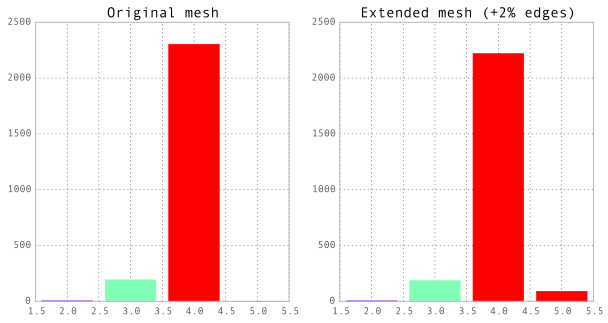

In [59]:
# original mesh degree distribution
dist = meshes[50]['mesh'].degree().values()

# extended mesh degree distribution
dist_e = ext_meshes[50]['mesh'].degree().values()

# degree extents, taken from the original and larger (extended) mesh
dist_min = min(dist)
dist_max = max(dist)
dist_e_min = min(dist_e)
dist_e_max = max(dist_e)

# create histograms for both distributions using the same bins
(hist, bins) = np.histogram(dist, bins = range(dist_min, dist_e_max + 1))
(hist_e, _) = np.histogram(dist_e, bins = range(dist_min, dist_e_max + 1))

# create a figure with three side-by-side sub-plots
fig = plt.figure(figsize = (10, 5))
colour_map = plt.cm.rainbow

# original mesh degree distribution
ax1 = fig.add_subplot(1, 2, 1)
_ = ax1.set_title("Original mesh")
bars = ax1.bar(bins[:-1], hist, align = 'center')
for i in xrange(len(bars)):
    bars[i].set_color(colour_map((bins[i] - dist_min + 0.0) / (dist_max - dist_min)))

# extended mesh degree distribution
ax2 = fig.add_subplot(1, 2, 2)
_ = ax2.set_title("Extended mesh (+2% edges)")
bars = ax2.bar(bins[:-1], hist_e, align = 'center')
for i in xrange(len(bars)):
    bars[i].set_color(colour_map((bins[i] - dist_min + 0.0) / (dist_max - dist_e_min)))
    
plt.savefig('mesh-ext-degrees.png')

So the additional edges add a very small number of extra nodes of higher degrees, but radically affect the diameter of the resulting network. We can see how little we've changed the "normal" node degrees by looking at a plot of the network using the same colours as above:

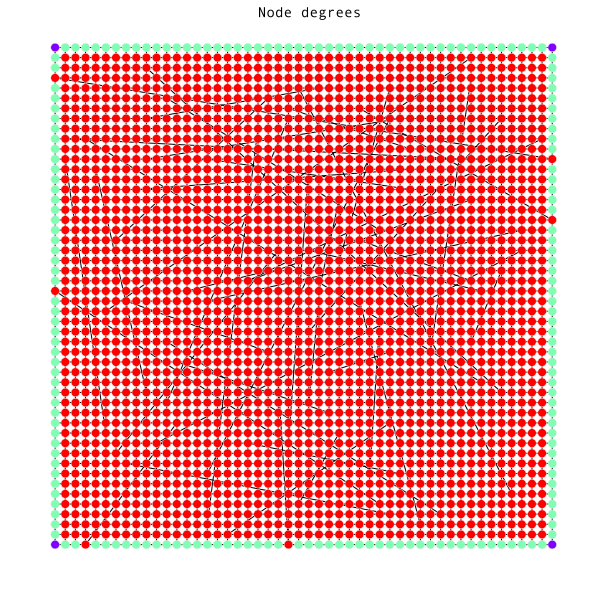

In [24]:
plt.figure(figsize = (10, 10))
_ = plt.title("Node degrees")
_ = plt.gca().set_axis_off()
draw_mesh(ext_meshes[50]['mesh'], with_labels = False, node_size = 75,
          node_color = dist_e, cmap = colour_map, vmin = dist_min, vmax = dist_max)
_ = plt.gca().set_xlim([-0.05, 1.05])
_ = plt.gca().set_ylim([-0.05, 1.05])

The 2% of extra edges has generated a few nodes with higher degrees scattered across the network, as well as some long-range edges between nodes that happen to be on opposite sides of the mesh.

What is happening is that the new edges create "short-cuts" through the network, allowing us to traverse from one side to the other much more quickly. It is this unexpected sensitivity that makes the study of complex networks and processes &ndash; well, complex. Any property that depends on diameter can be radically affected by only a small change in the topology of the network, since a very small number of additional edges are needed to shrink the diameter radically, and indeed to affect many other network properties.

## <span id="sec_dynamic_properties"</span> Dynamic properties

### Diffusion

### <a id="sec_adaptation"></a> Adaptation

<a id="adaptation"></a>